In [49]:
# Import merged df
import pandas as pd
merged = pd.read_csv('../data/processed/train_merged.csv')

display(merged.head())
print("Unique Video IDs:", merged["video_id"].nunique())
print("Unique User IDs:", merged["user_id"].nunique())


,user_id,video_id,watch_ratio,like_cnt,comment_cnt,share_cnt,feat
0,0,3649,1.273397,4435.809524,93.650794,133.063492,['9']
1,0,9598,1.244082,163.150000,76.300000,1.350000,['28']
2,0,5262,0.107613,21642.365079,463.301587,136.238095,['25']
3,0,1963,0.089885,14692.539683,407.730159,321.809524,"['9', '28']"
4,0,8234,0.078000,1396.777778,68.698413,2.873016,['6']


Unique Video IDs: 10728
Unique User IDs: 7176


In [50]:
# Let's build a user-item matrix
user_item_matrix = merged.pivot_table(
    index="user_id", columns="video_id", values="watch_ratio", fill_value=0
)
# Count non-zero entries per row (user) and column (video)
non_zero_rows = (user_item_matrix != 0).sum(axis=1)
non_zero_cols = (user_item_matrix != 0).sum(axis=0)

# Select top N rows and columns with the most non-zero values
top_users = non_zero_rows.sort_values(ascending=False).head(10).index
top_videos = non_zero_cols.sort_values(ascending=False).head(10).index

# Extract the submatrix
dense_matrix = user_item_matrix.loc[top_users, top_videos]

# Display the dense portion
print(dense_matrix.to_string())

video_id     5066      10069     1037      8145      1507      951       8769      1623      8770      5274 
user_id                                                                                                     
5733      0.000000  0.902517  0.626739  0.199476  0.769168  0.749175  1.025754  0.773419  0.630872  0.621210
2735      0.516385  1.009978  0.540784  0.283567  0.658836  0.750356  5.349795  0.978329  0.729884  1.483387
5412      0.384035  0.799770  0.616922  0.197489  0.650213  0.567549  1.268997  0.828976  0.785640  1.470484
816       0.467890  0.923289  0.435121  0.165942  0.617650  0.627767  0.960167  0.961888  0.889826  1.058387
6565      0.470521  0.921413  0.568514  0.175551  0.735345  0.872816  0.654450  0.883692  1.077907  1.038548
6753      0.457426  0.902682  0.668725  0.143339  0.728385  0.747508  1.089571  1.202030  0.699302  0.903871
703       0.443009  0.845762  0.441325  0.216748  0.568425  0.709159  0.740201  1.213277  0.617965  1.223468
6932      0.579879 

In [51]:
# User-level aggregates
user_agg = merged.groupby("user_id").agg(
    {
        "watch_ratio": ["mean", "std"],
        "like_cnt": "mean",
        "comment_cnt": "mean",
        "share_cnt": "mean",
    }
)
user_agg.columns = [
    "user_watch_ratio_mean",
    "user_watch_ratio_std",
    "user_like_mean",
    "user_comment_mean",
    "user_share_mean",
]
user_agg = user_agg.reset_index()

# Item-level aggregates
item_agg = merged.groupby("video_id").agg(
    {
        "watch_ratio": ["mean", "std", "count"],
        "like_cnt": "mean",
        "comment_cnt": "mean",
        "share_cnt": "mean",
    }
)
item_agg.columns = [
    "item_watch_ratio_mean",
    "item_watch_ratio_std",
    "item_like_mean",
    "item_comment_mean",
    "item_share_mean",
    "item_watch_ratio_count",
]
item_agg = item_agg.reset_index()

display(user_agg.head())
display(item_agg.head())

,user_id,user_watch_ratio_mean,user_watch_ratio_std,user_like_mean,user_comment_mean,user_share_mean
0,0,1.135499,3.841481,8739.252836,504.521404,289.652449
1,1,0.949711,1.111310,10965.857440,621.135881,443.663207
2,2,0.648013,0.737992,9558.910943,387.955591,204.393339
3,3,0.884631,0.698886,6801.686661,336.806781,266.754539
4,4,0.821825,0.868873,11116.545211,482.512424,233.746589


,video_id,item_watch_ratio_mean,item_watch_ratio_std,item_like_mean,item_comment_mean,item_share_mean,item_watch_ratio_count
0,0,1.481720,1.211005,117,388.777778,7.111111,1.666667
1,1,0.323187,0.299841,170,131.222222,0.936508,1.015873
2,2,1.485467,2.640496,131,50.476190,0.476190,0.301587
3,3,0.862029,4.023182,77,14.936508,0.111111,0.412698
4,4,0.617457,0.592396,5,0.057692,0.000000,0.000000


In [52]:
item_agg["popularity"] = item_agg["item_watch_ratio_count"]
item_agg["popularity_score"] = (
    item_agg["popularity"] - item_agg["popularity"].min()
) / (item_agg["popularity"].max() - item_agg["popularity"].min() + 1e-10)

print("Adding popularity score")
display(item_agg)

Adding popularity score


,video_id,item_watch_ratio_mean,item_watch_ratio_std,item_like_mean,item_comment_mean,item_share_mean,item_watch_ratio_count,popularity,popularity_score
0,0,1.481720,1.211005,117,388.777778,7.111111,1.666667,1.666667,0.000035
1,1,0.323187,0.299841,170,131.222222,0.936508,1.015873,1.015873,0.000022
2,2,1.485467,2.640496,131,50.476190,0.476190,0.301587,0.301587,0.000006
3,3,0.862029,4.023182,77,14.936508,0.111111,0.412698,0.412698,0.000009
4,4,0.617457,0.592396,5,0.057692,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...
10723,10723,2.241248,1.726224,4,24.000000,0.000000,0.000000,0.000000,0.000000
10724,10724,2.512859,2.168983,4,264.000000,29.000000,1.000000,1.000000,0.000021
10725,10725,0.833877,1.167053,11,851.000000,36.000000,3.000000,3.000000,0.000064
10726,10726,2.253196,1.909138,8,44.000000,0.000000,1.000000,1.000000,0.000021


In [54]:
# LET'S CREATE A ENGAGEMENT SCORE

# Formula between watch ratio, like ratio, comment ratio, and share ratio
w1, w2, w3, w4, w5 = 0.30, 0.10, 0.25, 0.15, 0.20  # Weights
item_agg["engagement_score"] = (
    w1 * item_agg["item_watch_ratio_mean"]
    + w2
    * (
        item_agg["item_watch_ratio_std"] + 0.01
    )  # Add small constant to avoid zero values
    + w3 * item_agg["item_like_mean"]
    + w4 * item_agg["item_comment_mean"]
    + w5 * item_agg["item_share_mean"]
)

# Sort by engagement score
item_agg = item_agg.sort_values("engagement_score", ascending=False)
display(item_agg.head())

,video_id,item_watch_ratio_mean,item_watch_ratio_std,item_like_mean,item_comment_mean,item_share_mean,item_watch_ratio_count,popularity,popularity_score,engagement_score
5066,5066,0.704540,1.481933,6183,621063.500000,52913.500000,10554.500000,10554.500000,0.223418,105288.335555
10552,10552,0.433625,0.930529,9737,513749.714286,16206.714286,6652.285714,6652.285714,0.140816,82738.274140
7814,7814,0.120476,0.230572,4504,264769.900000,8197.800000,1113.300000,1113.300000,0.023566,42481.105200
10589,10589,1.255997,2.530334,4720,229917.600000,27773.600000,1397.200000,1397.200000,0.029576,41222.990832
5027,5027,1.507538,2.521450,4706,221842.250000,7961.500000,919.750000,919.750000,0.019469,36045.842906


In [55]:
# Normalize engagement score
item_agg["engagement_score"] = (
    item_agg["engagement_score"] - item_agg["engagement_score"].min()
) / (
    item_agg["engagement_score"].max() - item_agg["engagement_score"].min() + 1e-10
)

# Create a hybrid score (engagement + popularity)
item_agg["hybrid_score"] = (
    0.7 * item_agg["engagement_score"] + 0.3 * item_agg["popularity_score"]
)

display(item_agg)

# Save the item_agg dataframe to a CSV file
item_agg.to_csv("../data/test/item_agg.csv", index=False)

,video_id,item_watch_ratio_mean,item_watch_ratio_std,item_like_mean,item_comment_mean,item_share_mean,item_watch_ratio_count,popularity,popularity_score,engagement_score,hybrid_score
5066,5066,0.704540,1.481933,6183,621063.500000,52913.500000,10554.500000,10554.500000,0.223418,1.000000,0.767025
10552,10552,0.433625,0.930529,9737,513749.714286,16206.714286,6652.285714,6652.285714,0.140816,0.785824,0.592321
7814,7814,0.120476,0.230572,4504,264769.900000,8197.800000,1113.300000,1113.300000,0.023566,0.403469,0.289498
10589,10589,1.255997,2.530334,4720,229917.600000,27773.600000,1397.200000,1397.200000,0.029576,0.391520,0.282937
5027,5027,1.507538,2.521450,4706,221842.250000,7961.500000,919.750000,919.750000,0.019469,0.342348,0.245485
...,...,...,...,...,...,...,...,...,...,...,...
10660,10660,2.261368,NaN,1,3.500000,0.500000,0.000000,0.000000,0.000000,NaN,NaN
10686,10686,2.331843,NaN,1,17.666667,0.333333,0.000000,0.000000,0.000000,NaN,NaN
10699,10699,2.354947,NaN,1,7.500000,0.000000,0.500000,0.500000,0.000011,NaN,NaN
10705,10705,6.342703,NaN,1,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,NaN


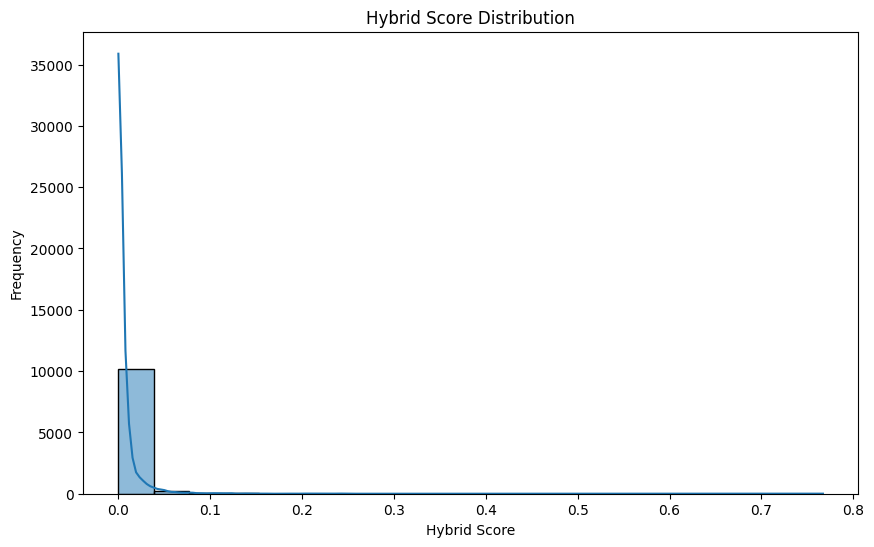

In [57]:
# Let's plot the hybrid score distribution
from matplotlib import pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.histplot(item_agg["hybrid_score"], bins=20, kde=True)
plt.title("Hybrid Score Distribution")
plt.xlabel("Hybrid Score")
plt.ylabel("Frequency")
plt.show()

In [58]:
# Evaluate the hybrid score
from sklearn.model_selection import train_test_split

train, test = train_test_split(merged, test_size=0.2, random_state=42)


def hit_rate_at_k(test_df, top_k_items):
    hits = 0
    total_users = test_df["user_id"].nunique()
    for user in test_df["user_id"].unique():
        user_items = test_df[test_df["user_id"] == user]["video_id"].values
        if any(item in top_k_items for item in user_items):
            hits += 1
    return hits / total_users


top_k_items = (
    item_agg.sort_values("hybrid_score", ascending=False).head(10)["video_id"].tolist()
)
hit_rate = hit_rate_at_k(test, top_k_items)
print(f"Hit Rate @10: {hit_rate:.4f}")

Hit Rate @10: 0.6633


In [59]:
def precision_at_k(test_df, item_scores, k=10):
    user_precision = []
    for user_id in test_df["user_id"].unique():
        actual_items = test_df[test_df["user_id"] == user_id]["video_id"].tolist()
        recommended_items = item_scores.sort_values("hybrid_score", ascending=False)[
            "video_id"
        ].tolist()[:k]
        hits = len(set(recommended_items) & set(actual_items))
        user_precision.append(hits / k)
    return sum(user_precision) / len(user_precision)


precision = precision_at_k(test, item_agg, k=10)
print(f"Precision @10: {precision:.4f}")

Precision @10: 0.1279


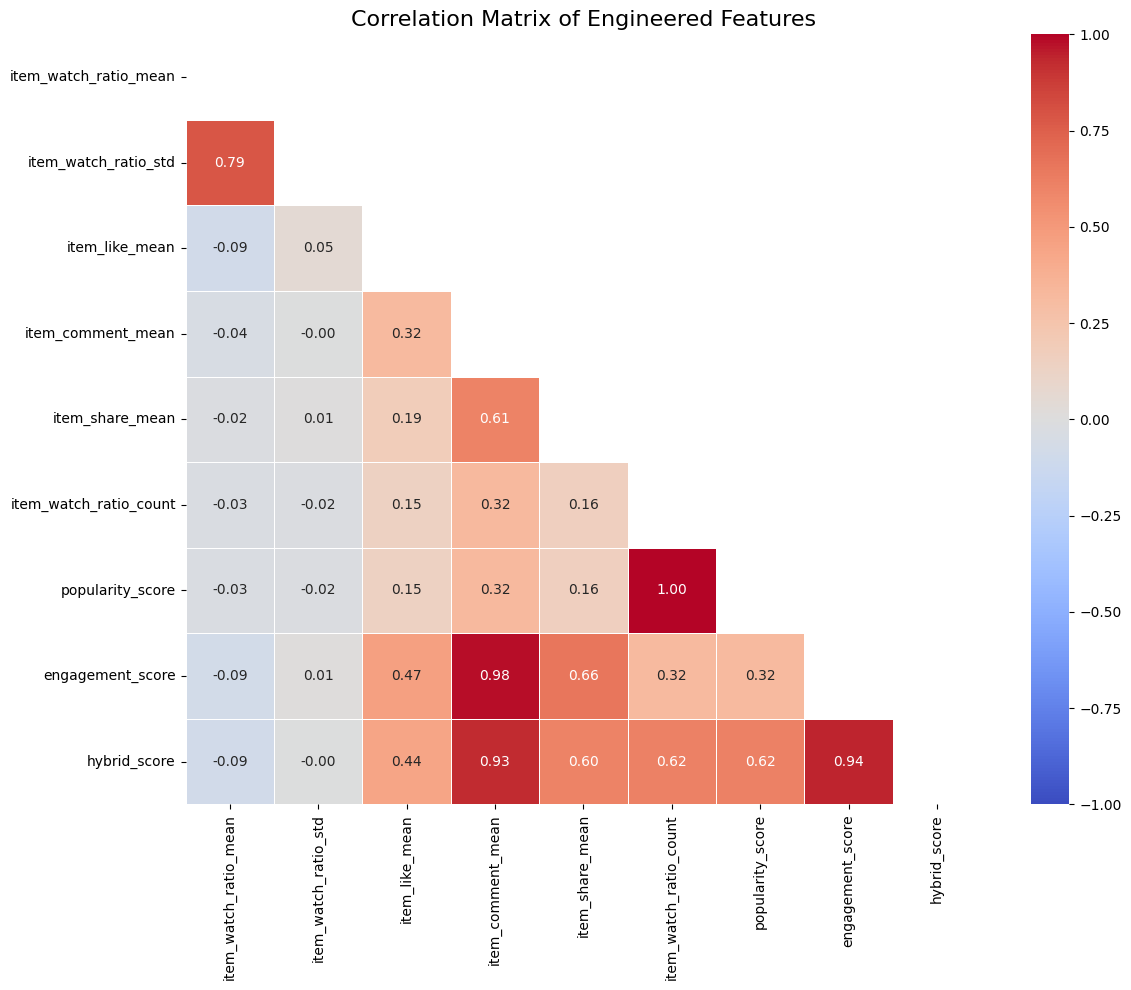

Top 5 strongest feature correlations:
item_watch_ratio_count and popularity_score: 1.0000
item_comment_mean and engagement_score: 0.9829
engagement_score and hybrid_score: 0.9430
item_comment_mean and hybrid_score: 0.9293
item_watch_ratio_mean and item_watch_ratio_std: 0.7859


In [30]:
# Create a correlation matrix of the engineered features
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Select the engineered features from item_agg
features = ['item_watch_ratio_mean', 'item_watch_ratio_std', 'item_like_mean', 
            'item_comment_mean', 'item_share_mean', 'item_watch_ratio_count',
            'popularity_score', 'engagement_score', 'hybrid_score']

# Calculate the correlation matrix
corr_matrix = item_agg[features].corr()

# Set up the matplotlib figure
plt.figure(figsize=(12, 10))

# Create a heatmap
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f', 
            linewidths=0.5, mask=mask, vmin=-1, vmax=1)

plt.title('Correlation Matrix of Engineered Features', fontsize=16)
plt.tight_layout()
plt.show()

# Print the strongest correlations
print("Top 5 strongest feature correlations:")
corr_pairs = []
for i in range(len(features)):
    for j in range(i+1, len(features)):
        corr_pairs.append((features[i], features[j], abs(corr_matrix.iloc[i, j])))

corr_pairs.sort(key=lambda x: x[2], reverse=True)
for pair in corr_pairs[:5]:
    print(f"{pair[0]} and {pair[1]}: {pair[2]:.4f}")
